# Week 3 Lecture 2 - The Haunted DAG

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [50]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp 
import random as rd
import pymc as pm
from matplotlib import pyplot as plt

def stdize(x):
    return (x-np.mean(x))/np.std(x)

## Categorical variables

When N things are factors we often use dummy variables (0,1)'s to represent n-1 of them against a 'baseline' category. This is very standard practice, something I have done for years. However there are problems, because the baseline category has priority over the other variables in that by setting a baseline, we are *a priori* stating that we know more about the baseline category than the other categories. In some cases this may be true - I have typically used the category for which we have the most inoformation as the baseline - but it can also get cumbersome, as we need to assert a prior for each category. 

Instead, let's use an **index variable**, which will make things much simpler. First import the !Kung data:

In [51]:
# Import data
kdata = pd.read_csv('../Data/howell.csv')
kdata['Sex'] = np.array(['Female','Male'])[kdata.male.values]
# Display top 5 rows
kdata.head()

,height,weight,age,male,Sex
0,151.765,47.825606,63.0,1,Male
1,139.700,36.485807,63.0,0,Female
2,136.525,31.864838,65.0,0,Female
3,156.845,53.041914,41.0,1,Male
4,145.415,41.276872,51.0,0,Female


Next, you need some code to do the indexing, where each factor gets it's own number. I have used the code below for about a decade for this, as it gives me both a list of unique values, as well as an index number for each observation to connect them to the list of unique values:

In [52]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

With this, we can easily make an index for male/female in the !Kung data:

In [53]:
Sex,Is = indexall(kdata.Sex.values)
Sex, Is

(['Male', 'Female'],
 array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 

Note that the categories are added on as they're encountered, so because the first entry is male, the male category is given the first index position, i.e. 0.

Next let's run two models, one using the dummy variable, and a second using the index variable:

In [54]:
with pm.Model() as dummy:
    # Baseline intercept
    β0 = pm.Normal('Female', 178, 20)
    # Male offset
    β1 = pm.Normal('Male', 0, 1)
    # Linear model
    μ = β0+β1*kdata.male.values
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=kdata.height.values)

In [55]:
with pm.Model() as indexed:
    # Intercepts
    β0 = pm.Normal('Intercpets', 178, 20, shape=2)
    # Linear model
    μ = β0[Is]
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=kdata.height.values)

In [56]:
with dummy:
    trace_d = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Female, Male, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [57]:
with indexed:
    trace_i = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercpets, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [58]:
# Look at dummy model results
pm.summary(trace_d)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Female,136.210,0.533,135.236,137.226,0.012,0.008,2110.0,2263.0,1.0
Male,4.394,0.660,3.086,5.548,0.014,0.010,2238.0,2315.0,1.0
SD_obs,9.997,0.003,9.992,10.000,0.000,0.000,2419.0,1470.0,1.0


In [59]:
# Look at index-based results
tmp = pm.summary(trace_i)
tmp['Label'] = Sex+['Sd_obs']
tmp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Label
Intercpets[0],142.373,0.631,141.211,143.585,0.011,0.008,3152.0,2670.0,1.0,Male
Intercpets[1],134.660,0.578,133.525,135.659,0.010,0.007,3298.0,2655.0,1.0,Female
SD_obs,9.997,0.003,9.992,10.000,0.000,0.000,2830.0,2112.0,1.0,Sd_obs


/Users/aoakley/Library/CloudStorage/OneDrive-DalhousieUniversity/Projects/Dalhousie/StatisticalRethinking_2024/venv/lib/python3.12/site-packages/arviz/data/base.py:265: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


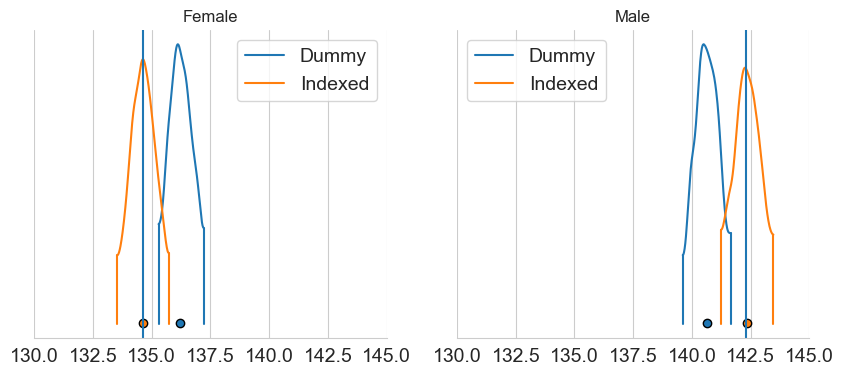

In [60]:
_, ax = plt.subplots(1,2, figsize=(10,4))

pm.plot_density([trace_d.posterior['Female'].values[0],trace_i.posterior['Intercpets'].values[0,None].T[1]], data_labels=['Dummy','Indexed'], ax=ax[0])
ax[0].axvline(np.mean(kdata.height.values[kdata.Sex.values=='Female']))
ax[0].set_xlim(130,145)
ax[0].set_title('Female')

pm.plot_density([trace_d.posterior['Female'].values[0]+trace_d.posterior['Male'].values[0],trace_i.posterior['Intercpets'].values[0,None].T[0]], data_labels=['Dummy','Indexed'], ax=ax[1])
ax[1].axvline(np.mean(kdata.height.values[kdata.Sex.values=='Male']))
ax[1].set_xlim(130,145)
ax[1].set_title('Male');

So what has happened here? Well it turns out the $N(0,1)$ prior for males in the dummy version was too informative. So if we go for something wider:

In [61]:
with pm.Model() as dummy:
    # Baseline intercept
    β0 = pm.Normal('Female', 178, 20)
    # Male offset
    β1 = pm.Normal('Male', 0, 5)
    # Linear model
    μ = β0+β1*kdata.male.values
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=kdata.height.values)

In [62]:
with dummy:
    trace_d = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Female, Male, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


/Users/aoakley/Library/CloudStorage/OneDrive-DalhousieUniversity/Projects/Dalhousie/StatisticalRethinking_2024/venv/lib/python3.12/site-packages/arviz/data/base.py:265: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


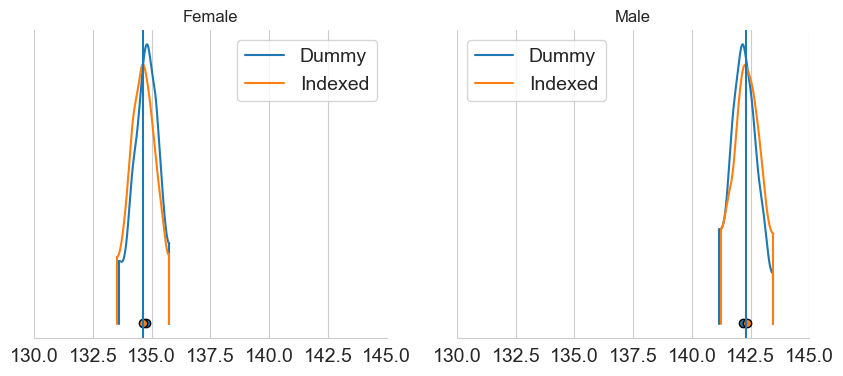

In [63]:
_, ax = plt.subplots(1,2, figsize=(10,4))

pm.plot_density([trace_d.posterior['Female'].values[0],trace_i.posterior['Intercpets'].values[0,None].T[1]], data_labels=['Dummy','Indexed'], ax=ax[0])
ax[0].axvline(np.mean(kdata.height.values[kdata.Sex.values=='Female']))
ax[0].set_xlim(130,145)
ax[0].set_title('Female')

pm.plot_density([trace_d.posterior['Female'].values[0]+trace_d.posterior['Male'].values[0],trace_i.posterior['Intercpets'].values[0,None].T[0]], data_labels=['Dummy','Indexed'], ax=ax[1])
ax[1].axvline(np.mean(kdata.height.values[kdata.Sex.values=='Male']))
ax[1].set_xlim(130,145)
ax[1].set_title('Male');

So either version can get us to a simliar place, however the indexed version tends to be far easier to work with. 

# Selection distortion effects

Among the scariest aspects of statistical models is that things can become spurriously correlated due to the inclusion or exclusion of another, lurking variable. If we don't know about this, and how such things can be induced, we're doomed to report stuff that is complete malarky, adding noise to the scientific cannon. I'm sure I've done this at some point. But knowing is half the battle, so let's start with something called the selection-distortion effect. This is when a third, intervening variable is added that selects for a subset of the data and induces a spurroius correlation. This is something that is known as collider bias (we'll explain below), and it can be a big problem.

To illustrate, we can take a look at the simulated scientific distortion example on p162 in the book:


In [64]:
# Set random number seed to get same answers
#np.random.seed(seed=1914)

# Number of grant proposals
N = 200
# Proportion to select
prop = 0.1

# Uncorrelated Newsworthiness and trustworthiness scores
nw = np.random.normal(0,1,N)
tw = np.random.normal(0,1,N)

# Select top 10% of combined scores
score = nw+tw
indx = score>np.quantile(score,.9)

# How correlated?
cor_ = np.corrcoef(nw[indx], tw[indx])[0][1]
cor_

-0.5659326020968429

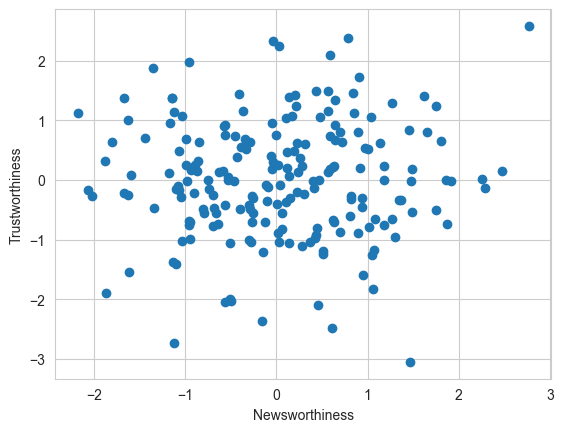

In [65]:
plt.scatter(nw,tw)
plt.xlabel('Newsworthiness')
plt.ylabel('Trustworthiness')
plt.savefig('seldis0.jpg',dpi=300);

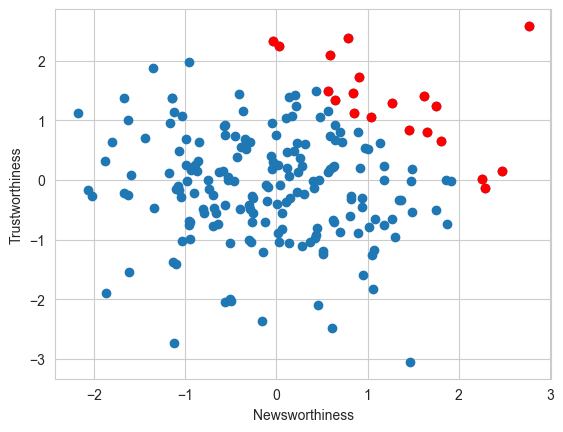

In [66]:
plt.scatter(nw,tw)
plt.scatter(nw[indx],tw[indx],c='red')
plt.xlabel('Newsworthiness')
plt.ylabel('Trustworthiness')
plt.savefig('seldis.jpg',dpi=300);

In most simulations, the red dots will have a negative correlation, entirely due to their having the highest total value for the two covariates. Provided we don't condition on score, this isn't a problem. If we did, we would induce a spurrious correlation that doesn't apply to the data as a whole. Tricky eh?

# DAGs and why to use 'em

Directed Acyclic Graphs are a really important development in modelling observational data (if you've done an experiment, then all power to you), because they give us some sort of ground to stand on in thinking about causality. Again, much of this creit goes to [Judea Pearl](https://en.wikipedia.org/wiki/Judea_Pearl), whose thinking around causality is nobel-prize worthy.

Pearl set out 4 key rules, that cover all the major bases. If you address these four things once you've made a causal model, causal inference can follow.

## The fork and the pipe

The fork and the pipe are equivalent mathematically, in that they are about conditing on an intermediating variable, but for the fork to break a spurrious correlation, and in the not conditioning to estimate an effect. We saw a fork example in the Southern divorce example, with a fork at marriage age (A) that, once conditioned on, breaks the association between marriage rate (M) and divorce (D).

For a pipe example, we can simulate some data relating to treatment effects on plants. The pipe is that the treatment (T) reduces fungus (F) and therfore aids in the growth of a plant (G).

In [67]:
# Set number of plants
N = 100

# Simulate initial heights
h0 = np.random.normal(10,2,N)

# Assign treatments
treatment = np.random.choice((0,1),N)

# Simulate fungus conditional on treatment
beta_t = 0.4
fungus = np.random.binomial(1,.5-beta_t*treatment)

# Generate end heights
h1 = h0+np.random.normal(5-3*fungus,1)

In [68]:
fungus

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

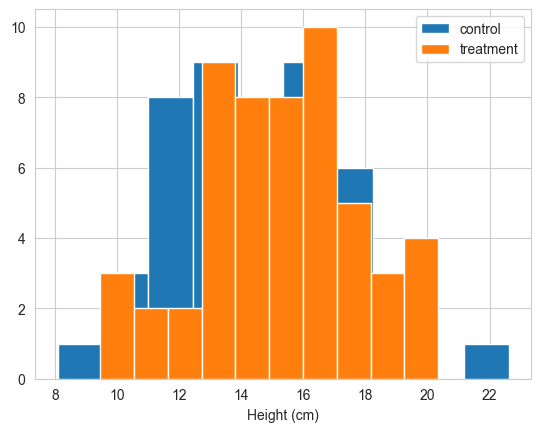

In [69]:
plt.hist(h1[treatment==0],label='control')
plt.hist(h1[treatment==1],label='treatment')
plt.xlabel('Height (cm)')
plt.legend()
plt.savefig('treat.jpg', dpi=300);

You can see from what we've simulated that things are bimodial according to if the plants received the treatment or not. So, we have covariates for `initial height`, `treatment`, and `fungus` - to the multiple regression!

In [70]:
with pm.Model() as plants:
    # Intercept
    β0 = pm.Lognormal('Intercept', 0, 0.2)
    # Treatment effect
    β1 = pm.Normal('Treatment', 0, 0.5)
    # Fungal effect
    β2 = pm.Normal('Fungus', 0, 0.5)
    # Linear model
    μ = (β0+β1*treatment+β2*fungus)*h0
    # Error
    σ = pm.Exponential('SD_obs', 1)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=h1)

In [71]:
with plants:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Treatment, Fungus, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [72]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Fungus,-0.275,0.027,-0.326,-0.225,0.001,0.000,2452.0,2793.0,1.0
Intercept,1.445,0.020,1.407,1.481,0.000,0.000,2236.0,2615.0,1.0
SD_obs,1.139,0.083,0.989,1.296,0.002,0.001,2652.0,2236.0,1.0
Treatment,0.010,0.023,-0.032,0.056,0.000,0.000,2392.0,2709.0,1.0


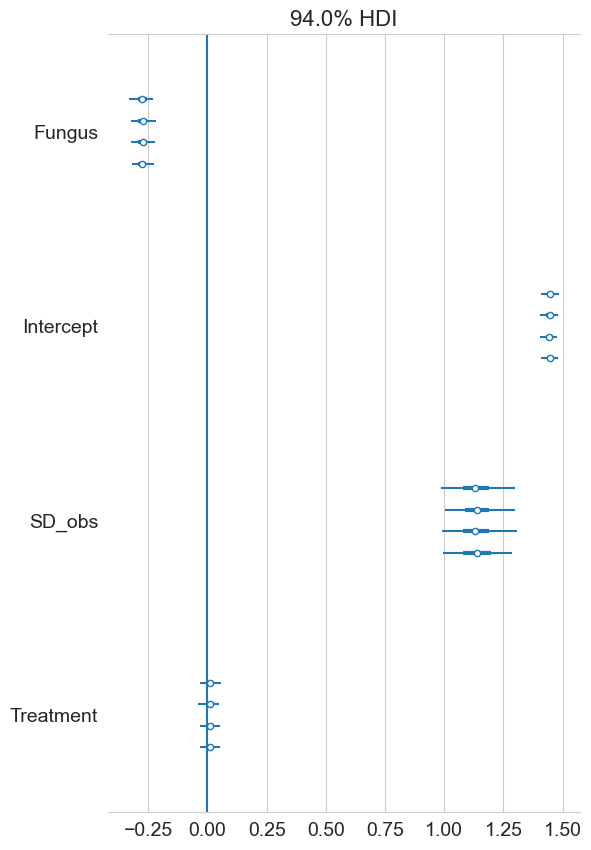

In [73]:
pm.plot_forest(trace)
plt.axvline(0)
plt.tight_layout()
plt.savefig('pipe.jpg',dpi=300);

What the heck? We know the treatment will reduce the probability of fungus by 0.4, and that fungal-infested plants will grow an average of 3cm less (we made the data). So what's going on? Well, conditional on knowing that there is fungus, there is no benefit to knowing about the treatement, whereas conditional on knowing treatment it remains worth knowing if there is fungus (fungus happens to treated plants too). In this case fungus lies along the pipe between treatment and outcome, blocking information that would flow from treatment. Therefore if we want to estimate the effect of treatment we need a model without the post-treatment outcome, fungus:

In [74]:
with pm.Model() as plants_t:
    # Intercept
    β0 = pm.Lognormal('Intercept', 0, 0.2)
    # Treatment effect
    β1 = pm.Normal('Treatment', 0, 0.5)
    # Linear model
    μ = (β0+β1*treatment)*h0
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=h1)

In [75]:
with plants_t:
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Treatment, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [76]:
pm.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.310,0.021,1.270,1.349,0.000,0.000,2441.0,2214.0,1.0
SD_obs,1.640,0.118,1.416,1.862,0.002,0.002,2635.0,2417.0,1.0
Treatment,0.131,0.029,0.076,0.185,0.001,0.000,2519.0,2317.0,1.0


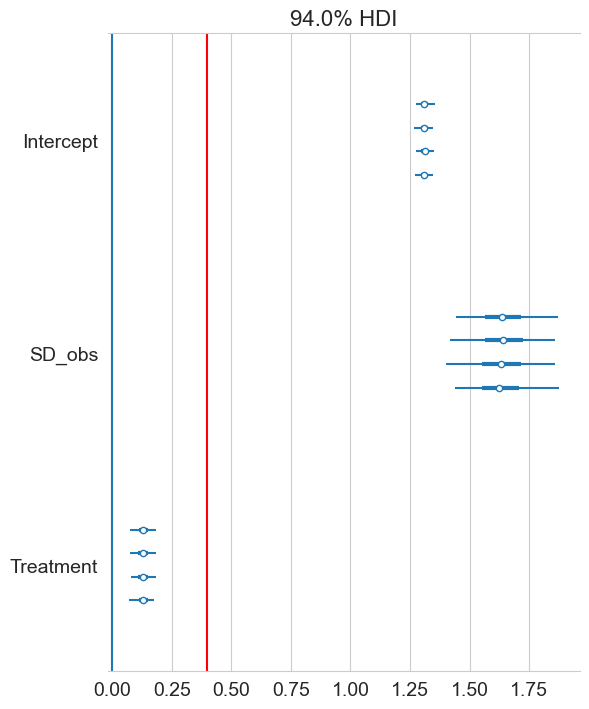

In [77]:
pm.plot_forest(trace_t)
plt.axvline(0)
plt.axvline(beta_t,c='red')
plt.tight_layout()
plt.savefig('tpipe.jpg',dpi=300);

But now our effect is 0.15 (or so), not 0.4 - what's going on? Well, our known treatment effect of 0.4 is the reduction in the probability of fungus, while our treatment estimate above is on the effect of treatment on height. So we need to convert back to the probability scale, or convert our known number to the height effect scale. 

In [78]:
# Average difference between full and fungal growth
avg_diff = np.mean((h1-h0)[fungus==0])-np.mean((h1-h0)[fungus==1])
avg_diff

3.0323786109961843

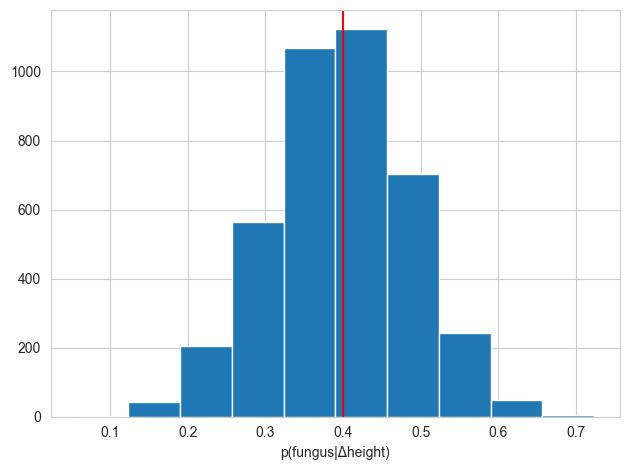

In [79]:
plt.hist(trace_t.posterior['Treatment'].values.flatten()*avg_diff)
plt.axvline(beta_t,c='red')
plt.xlabel('p(fungus|Δheight)')
plt.tight_layout()
plt.savefig('effect.jpg',dpi=300);

You can take a look at this model using the `daggity` package in R, or online at [DAGitty.net](http://dagitty.net/dags.html)

# Collider bias

McElreath has an agent-based model of happiness baked into his `rethinking` package, as outlined on p177, with five key conditions

    1. Each year, 20 people are born with uniformly distributed happiness values.
    2. Each year, each person ages one year. Happiness does not change.
    3. At age 18, individuals can become married. The odds of marriage each year are proportional to a person's happiness.
    4. Once married, individuals remain married.
    5. After age 65, individuals leave the sample (They move to Spain.)
    
We can import that simulated happiness data to work with it:

In [80]:
# Happiness data
hdata = pd.read_csv('../Data/happiness1.csv')
hdata.head()

,Unnamed: 0,age,married,happiness
0,1,65,0,-2.000000
1,2,65,0,-1.789474
2,3,65,1,-1.578947
3,4,65,0,-1.368421
4,5,65,0,-1.157895


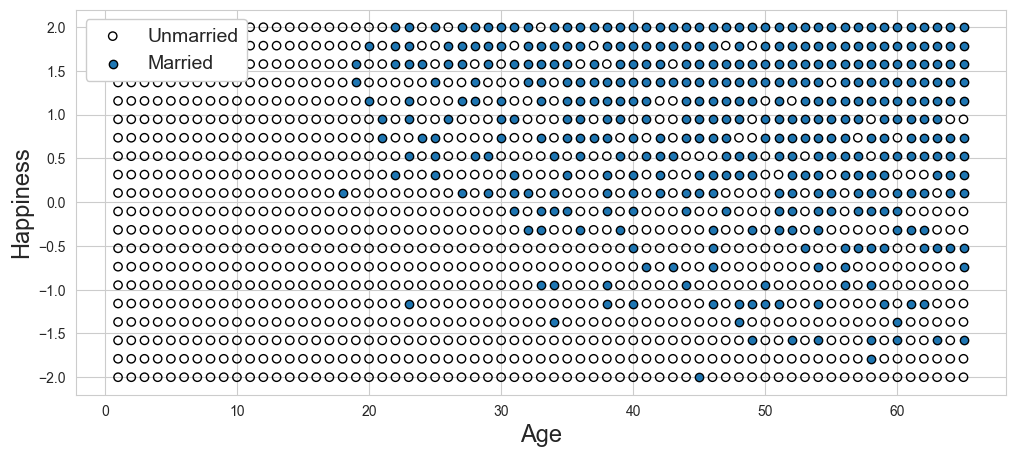

In [81]:
fig = plt.figure(figsize=(12, 5))
plt.scatter(hdata.age[hdata.married==0],hdata.happiness[hdata.married==0], facecolors='none', edgecolors='black', label='Unmarried')
plt.scatter(hdata.age[hdata.married==1],hdata.happiness[hdata.married==1], edgecolors='black',  label='Married')
plt.xlabel('Age', fontsize=17)
plt.ylabel('Happiness', fontsize=17)
plt.legend(loc='upper left', framealpha=1, fontsize=14)
plt.savefig('happy.jpg',dpi=300);


The data above assumes happiness is uniformally distributed and never changes. 

So, pretending we don't know anything about how this was generated, what sort of model should we build? 'Is age related to happiness' we might ask. And we should control for the effect of marriage, right?? A model representing these things would be

$$
\mu_i = \beta_{M[i]}+\beta_{A}A_i
$$

with indexed married/not-married intercepts ($\beta_{M[i]}$) and a parameter for changing happieness with age ($\beta_{A}$). 

What makes for sensible priors sensible here? It's difficult to think about how much happiness should increase or decrease per year of age. First we can chuck out the kids, as they can't marry. Then if we scale the ages from 18 to 65 to be over the range 1 to 0, we know the range for happiness is -2 to 2, so we should be cover that range (i.e. 4 units) over the 0 to 1 interval of scaled ages. As 95% of the posterior mass is within 2SD of the mean, setting the prior SD to 4/2 will capture most of the range.

For the intercept, now equal to 0 at age 18, we can also span the range, using a $N(0,1)$ prior.


In PyMC this would be:


In [105]:
# Adults only
aindx = hdata.age.values>17
# Marriage index
Im = hdata.married.values[aindx]
# Age - scaled so as to be between 0 and 1
AGE = (hdata.age.values[aindx]-18)/(65-18)
# Happiness
H = hdata.happiness.values[aindx]

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [83]:
with pm.Model() as happy:
    # Intercept
    β0 = pm.Normal('Marriage', 0, 1, shape=2)
    # Age effect
    β1 = pm.Normal('Age', 0, 2)
    # Linear model
    μ = β0[Im]+β1*AGE
    # Error
    σ = pm.Exponential('SD_obs', 1)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=H)

In [84]:
with happy:
    trace_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Marriage, Age, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [85]:
pm.summary(trace_h)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age,-0.744,0.113,-0.963,-0.539,0.003,0.002,1546.0,1836.0,1.00
Marriage[0],-0.239,0.063,-0.353,-0.117,0.002,0.001,1699.0,1939.0,1.01
Marriage[1],1.255,0.086,1.088,1.410,0.002,0.001,1699.0,2039.0,1.00
SD_obs,0.992,0.023,0.948,1.034,0.000,0.000,2600.0,2314.0,1.00


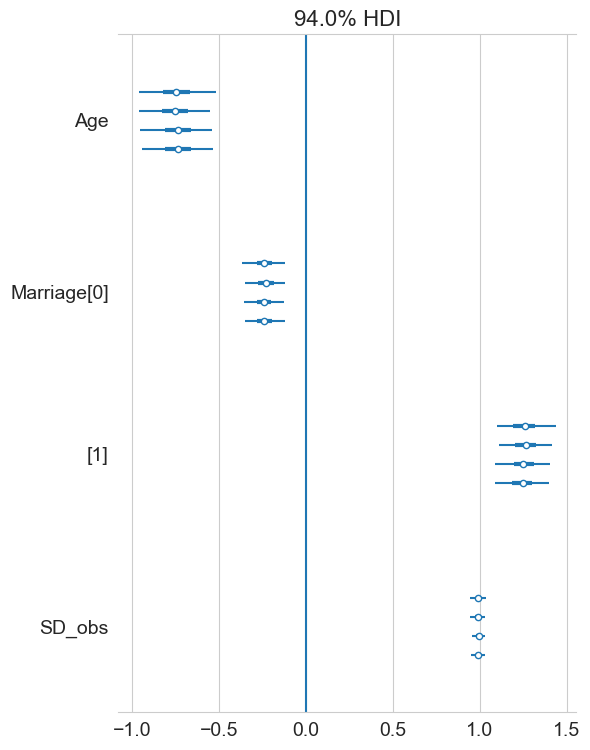

In [86]:
pm.plot_forest(trace_h)
plt.axvline(0)
plt.tight_layout()
plt.savefig('happy1.jpg',dpi=300);

Waaait a minute - we know that happiness is consistent across ages (everyone keeps their intial happiness levels in the simulation), so what the heck is the model doing? It is refelcting the model it was given, one where marriage acts as a collider to open a path between age and happiness. How does this occur? Well it occurs because marriage is a common consequence of both age and happiness - people who are older and happier are more likely to be married. Take a look again at the data: 

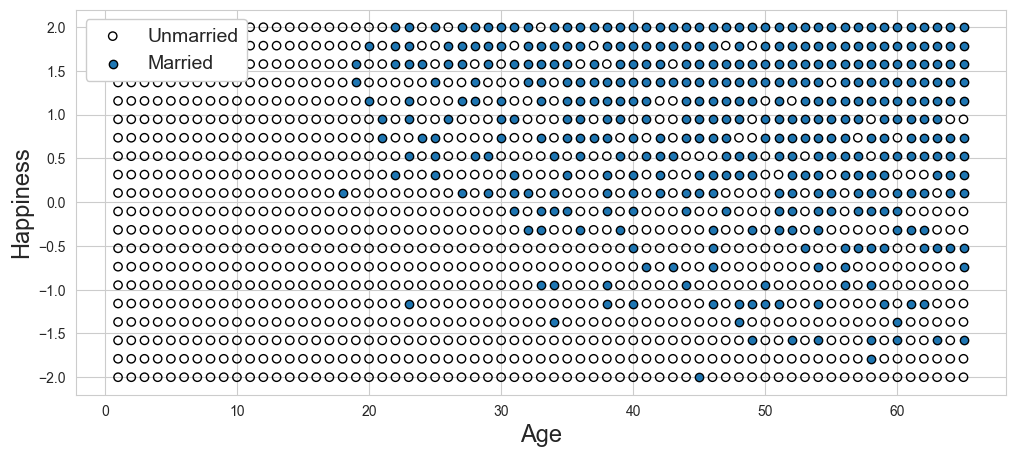

In [87]:
fig = plt.figure(figsize=(12, 5))
plt.scatter(hdata.age[hdata.married==0],hdata.happiness[hdata.married==0], facecolors='none', edgecolors='black', label='Unmarried')
plt.scatter(hdata.age[hdata.married==1],hdata.happiness[hdata.married==1], edgecolors='black',  label='Married')
plt.xlabel('Age', fontsize=17)
plt.ylabel('Happiness', fontsize=17)
plt.legend(loc='upper left', framealpha=1, fontsize=14);

And you can see it - the older, happier people tend to be married. The collider. If instead of including it, we leave the collider path closed, we get the right result:

In [88]:
with pm.Model() as happy2:
    # Age effect
    β1 = pm.Normal('Age', 0, 2)
    # Linear model
    μ = β1*AGE
    # Error
    σ = pm.Exponential('SD_obs', 1)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=H)

In [89]:
with happy2:
    trace_h2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Age, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [90]:
pm.summary(trace_h2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age,0.001,0.070,-0.126,0.136,0.001,0.001,3912.0,3130.0,1.0
SD_obs,1.215,0.028,1.167,1.269,0.000,0.000,3904.0,2678.0,1.0


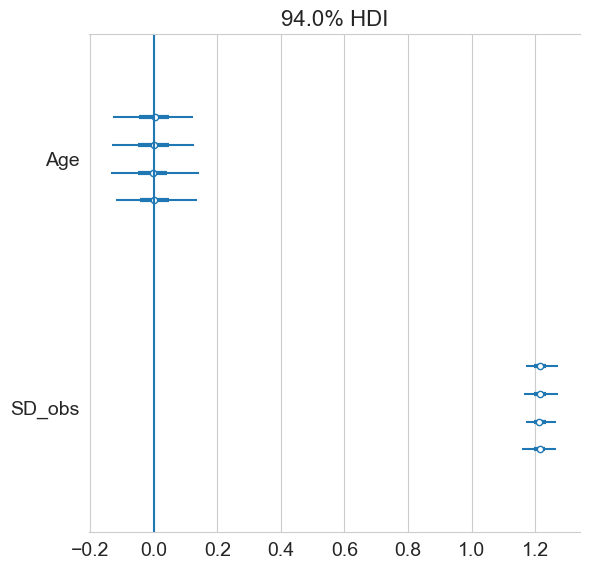

In [91]:
pm.plot_forest(trace_h2)
plt.axvline(0)
plt.tight_layout()
plt.savefig('happy2.jpg',dpi=300);

# The Haunted DAG

Of all the many difficulties lurking in our statistical models, perhaps the scariest is that our estimates are influcenced by something we haven't measured, or even thought of. How can we deal with that? First let's look at the grandparents example. Here we are looking at the influence of both parent (P) and grandparent (G) education on children's education (C). The DAG for this is simple in the sense that $G\rightarrow P \rightarrow C$ (grandparents influence their kids, who influence their kids) AND $G\rightarrow C$ (grandparents influence their grandkids directly). 

![](GPC.jpg)

But what if we have a third, lurking variable $U$, that is a common influence on both parents and children? This could be something like the neighbourhood that the parents and kids live in, and by conditioning on the parents, we open up a backdoor path from $G$ to $C$ (via $U$)

![](GPCU.jpg)

What's messed up about this is that this can happen without our even knowing about $U$ or having ever observed it. Here's a simulation of how it works:

In [92]:
# Number of families
N = 200

# Direct effect of G on P
b_GP = 1

# Direct effect of G on C
b_GC = 0

# Direct effect of P on C
b_PC = 1

# Direct effect of U on P and C
b_U = 2

With these parameter estimates we can simulate from some random normals:

In [106]:
# Simulate neighbourhood effects - some are positive (+1*U) some are negative (-1*U)
U = 2*np.random.binomial(1,0.5,N) - 1

# Simulate standard normal grandparents
G = np.random.normal(0,1,N)

# Simulate Parents, conditional on their influeces (G and U)
P = np.random.normal(b_GP*G+b_U*U,1,N)

# Simulate Children, conditional on their influeces (G, P, and U)
C = np.random.normal(b_PC*P+b_GC*G+b_U*U,1,N)

array([-1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,
        1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,
        1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,
       -1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
        1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,
        1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1, -1])

Naievely running a regression model with parents and grandparents included, we get:

In [94]:
with pm.Model() as edu:
    # Intercept
    β0 = pm.Normal('Intercept', 0, 1)
    # Grandparent effect
    βg = pm.Normal('Grandparents', 0, 1)
    # Parent effect
    βp = pm.Normal('Parents', 0, 1)
    # Linear model
    μ = β0+βg*G+βp*P
    # Error
    σ = pm.Exponential('SD_obs', 1)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=C)

In [95]:
with edu:
    trace_e = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Grandparents, Parents, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [96]:
pm.summary(trace_e)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Grandparents,-0.904,0.100,-1.093,-0.723,0.002,0.001,3420.0,3139.0,1.0
Intercept,-0.014,0.092,-0.190,0.157,0.001,0.001,4652.0,3081.0,1.0
Parents,1.838,0.042,1.761,1.916,0.001,0.000,3702.0,3001.0,1.0
SD_obs,1.306,0.065,1.183,1.425,0.001,0.001,6009.0,3250.0,1.0


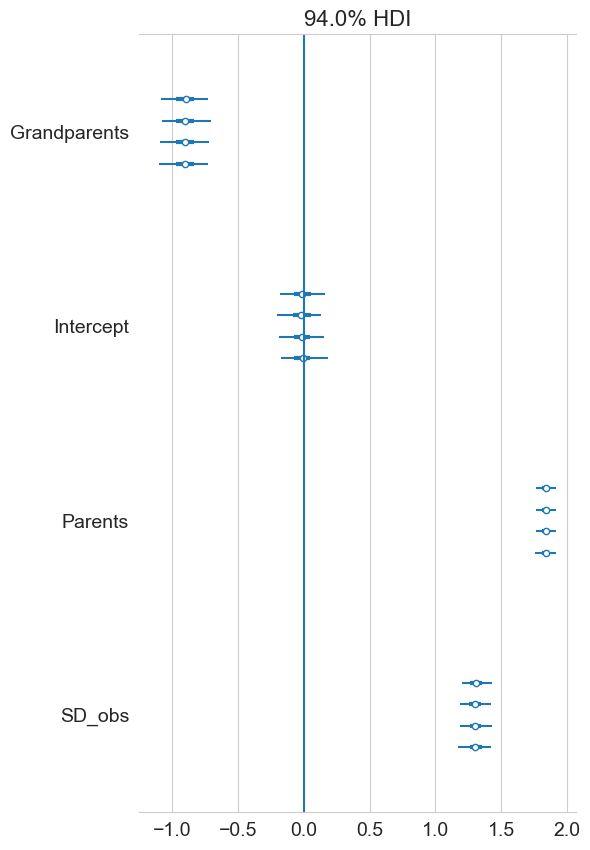

In [97]:
pm.plot_forest(trace_e)
plt.axvline(0)
plt.tight_layout()
plt.savefig('pappy.jpg',dpi=300);

So without knowing about the neighbourhood effect $U$, it seems like grandparents are messing up their grandkids!

From the DAG it's clear that conditioning on P opens up a backdoor path for grandparents to influence their grandkids indirectly through their kids choice of neighbourhood. 

To see this mechanically, take a look at the following figure:

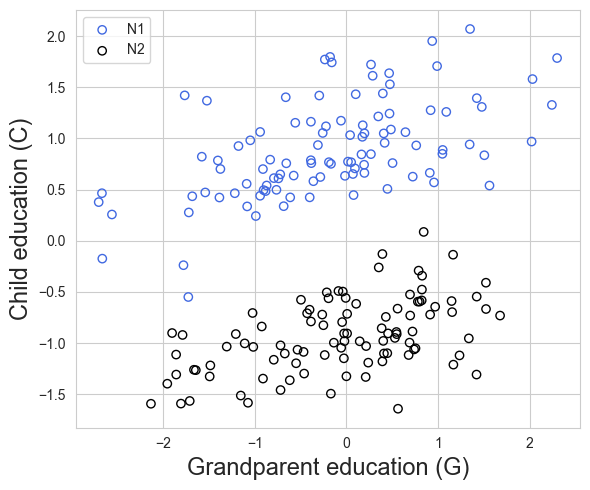

In [98]:
C_ = stdize(C)
fig = plt.figure(figsize=(6, 5))

plt.scatter(G[U==1],C_[U==1], facecolors='none', edgecolors='royalblue',label='N1')
plt.scatter(G[U==-1],C_[U==-1], facecolors='none', edgecolors='black',label='N2')
plt.xlabel('Grandparent education (G)', fontsize=17)
plt.ylabel('Child education (C)', fontsize=17)
plt.legend()
plt.tight_layout()
plt.savefig('GC.jpg',dpi=300);

First notice the positive relationship between G and C, even though the direct effect is 0 - how? Well $G\rightarrow P = 1$ and $P\rightarrow C = 1$ so there is a pipe from $G\rightarrow C$ evident in the plot. Now look what happens when we condition on parents - remember that this is a form of selection? - and highlight those parents who happen to lie between the 45th and 60th percentiles of education.

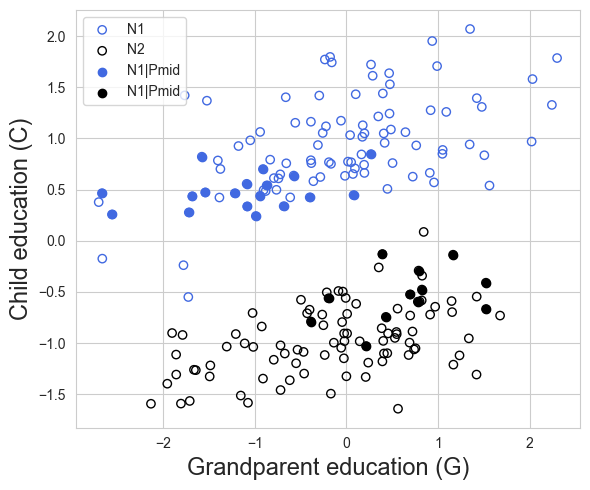

In [99]:
# Flag parents that lie within percentile range
pflag_1 = 1*(P[U==1]>np.percentile(P,45))*(P[U==1]<np.percentile(P,60))
pflag_2 = 1*(P[U==-1]>np.percentile(P,45))*(P[U==-1]<np.percentile(P,60))

fig = plt.figure(figsize=(6, 5))

# Plot all points
plt.scatter(G[U==1],C_[U==1], facecolors='none', edgecolors='royalblue',label='N1')
plt.scatter(G[U==-1],C_[U==-1], facecolors='none', edgecolors='black',label='N2')

# Plot filled points 
plt.scatter(G[U==1][pflag_1==1],C_[U==1][pflag_1==1], facecolors='royalblue', edgecolors='royalblue',label='N1|Pmid')
plt.scatter(G[U==-1][pflag_2==1],C_[U==-1][pflag_2==1], facecolors='black', edgecolors='black',label='N1|Pmid')

plt.xlabel('Grandparent education (G)', fontsize=17)
plt.ylabel('Child education (C)', fontsize=17)
plt.legend()
plt.tight_layout()
plt.savefig('GC2.jpg',dpi=300);

And there it is, hidden among the data - by conditioning on P, a negative association has been induced between grandparents and children that has entirely to do with the fact that the unmeasured neighbourhood effect is operating in the background, drawing down child scores in a hidden way. Spooky!

So what should we do about all this? Well if we had accounted for U:

In [100]:
with pm.Model() as edu_new:
    # Intercept
    β0 = pm.Normal('Intercept', 0, 1)
    # Grandparent effect
    βg = pm.Normal('Grandparents', 0, 1)
    # Parent effect
    βp = pm.Normal('Parents', 0, 1)
    # Neighbourhood effect
    βu = pm.Normal('Neighbourhood', 0, 1)
    # Linear model
    μ = β0+βg*G+βp*P+βu*U
    # Error
    σ = pm.Exponential('SD_obs', 1)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=C)

In [101]:
with edu_new:
    trace_n = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Grandparents, Parents, Neighbourhood, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [102]:
pm.summary(trace_n)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Grandparents,-0.185,0.100,-0.383,-0.005,0.002,0.002,2099.0,2399.0,1.0
Intercept,0.028,0.074,-0.108,0.168,0.001,0.001,3837.0,2454.0,1.0
Neighbourhood,1.730,0.151,1.455,2.015,0.003,0.002,1947.0,2217.0,1.0
Parents,1.134,0.069,1.005,1.264,0.002,0.001,1871.0,2197.0,1.0
SD_obs,1.015,0.053,0.920,1.120,0.001,0.001,3225.0,2491.0,1.0


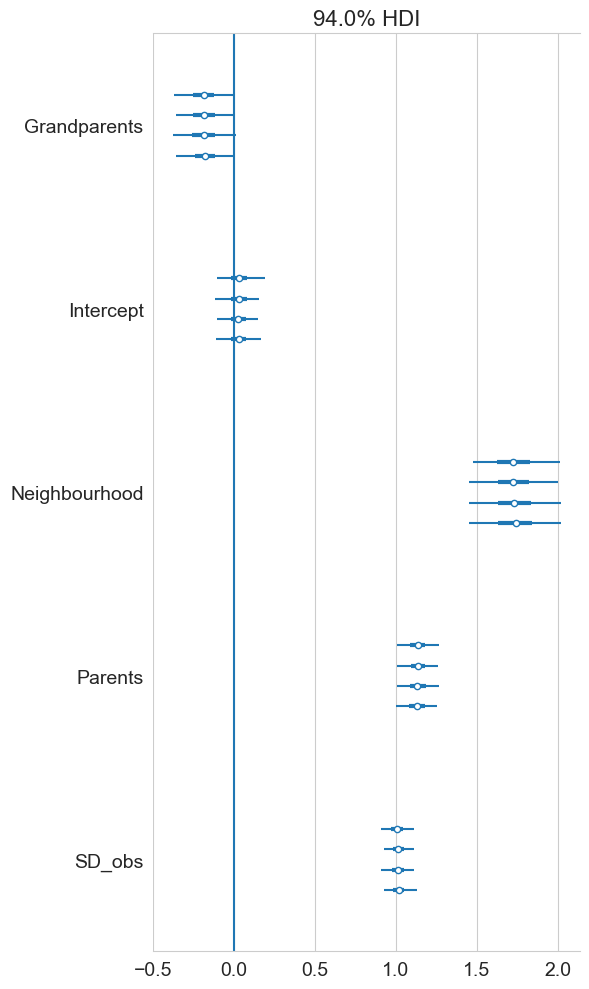

In [103]:
pm.plot_forest(trace_n)
plt.axvline(0)
plt.tight_layout()
plt.savefig('pappyU.jpg',dpi=300);

It gets it right. But this is kind of unsatisfactory, as we didn't know there was a problem, U stands for unmeasured after all.

For now, we'll remain haunted...